# Agent Pick Rates on certain Maps

Original Pick Rate Values:
0    69%
1    56%
2    56%
3    44%
4    38%
5    31%
6    31%
7    25%
8    25%
9    25%
Name: Pick Rate, dtype: object
Cleaned Pick Rate Values:
count    24840.000000
mean        20.846940
std         32.861284
min          0.000000
25%          0.000000
50%          0.000000
75%         38.000000
max        100.000000
Name: Pick Rate, dtype: float64
Filtered Data contains 2640 rows.
Pivot Table:
Map            Abyss  All Maps  Ascent       Bind  Haven      Icebox  \
Agent                                                                  
astra      56.916667     10.80    0.00  13.428571    0.0    0.000000   
breach      0.000000     23.40    0.00   0.000000   66.7    0.000000   
brimstone   0.000000     12.40    0.00  74.857143    0.0    0.000000   
chamber     0.000000      4.04    0.00   7.642857    0.0    0.000000   
clove       0.000000      4.24    9.50   0.000000    0.0    0.000000   
cypher     77.083333     39.08   40.75  15.500000   77.8    0.00000

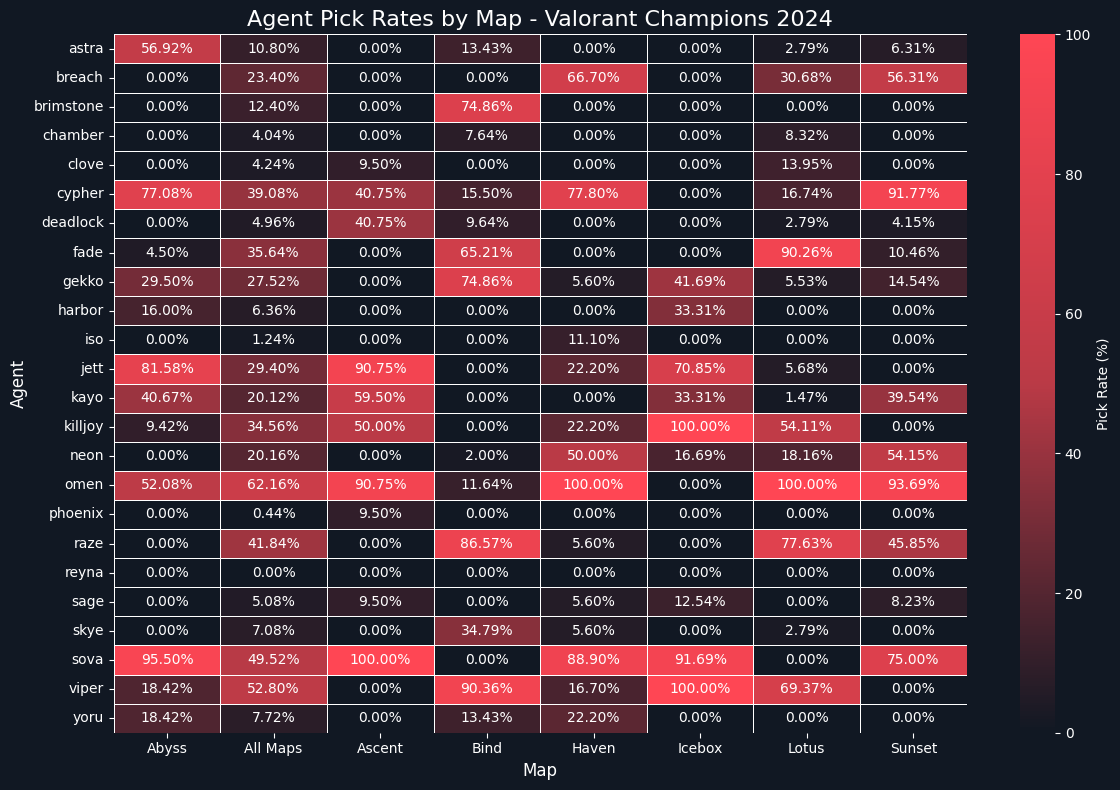

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

file_path = "valorant_data/vct_2024/agents/agents_pick_rates.csv"
data = pd.read_csv(file_path)

print("Original Pick Rate Values:")
print(data["Pick Rate"].head(10))

data["Pick Rate"] = data["Pick Rate"].str.replace("%", "", regex=True).astype(float)

print("Cleaned Pick Rate Values:")
print(data["Pick Rate"].describe())

filtered_data = data[data["Tournament"] == "Valorant Champions 2024"]
print(f"Filtered Data contains {len(filtered_data)} rows.")

heatmap_data = filtered_data.pivot_table(
    index="Agent", columns="Map", values="Pick Rate", aggfunc="mean"
)

heatmap_data = heatmap_data.fillna(0)
print("Pivot Table:")
print(heatmap_data)


agent_distances = pdist(heatmap_data, metric='euclidean')
agent_linkage = linkage(agent_distances, method='ward')

map_distances = pdist(heatmap_data.T, metric='euclidean') 
map_linkage = linkage(map_distances, method='ward')

agent_dendrogram = dendrogram(agent_linkage, no_plot=True)
map_dendrogram = dendrogram(map_linkage, no_plot=True)

reordered_agents = agent_dendrogram['leaves']
reordered_maps = map_dendrogram['leaves']

ordered_heatmap_data = heatmap_data.iloc[reordered_agents, reordered_maps]

ordered_heatmap_data = ordered_heatmap_data[sorted(ordered_heatmap_data.columns)]
ordered_heatmap_data = ordered_heatmap_data.loc[sorted(ordered_heatmap_data.index)]

colors = ["#111823", "#ba3a46", "#ff4654"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(12, 8), facecolor="#111823")

sns.heatmap(
    ordered_heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=0.5,
    cbar_kws={"label": "Pick Rate (%)"},
    annot_kws={"size": 10} 
)

for text in plt.gca().texts:
    new_value = f"{float(text.get_text()):.2f}%"
    text.set_text(new_value)

plt.title("Agent Pick Rates by Map - Valorant Champions 2024", fontsize=16, color="white")
plt.xlabel("Map", fontsize=12, color="white")
plt.ylabel("Agent", fontsize=12, color="white")

plt.gca().tick_params(axis="x", colors="white")
plt.gca().tick_params(axis="y", colors="white")

plt.gcf().axes[-1].yaxis.label.set_color('white')
plt.gcf().axes[-1].tick_params(axis='y', colors='white')

plt.grid(False)  

plt.tight_layout()
plt.show()


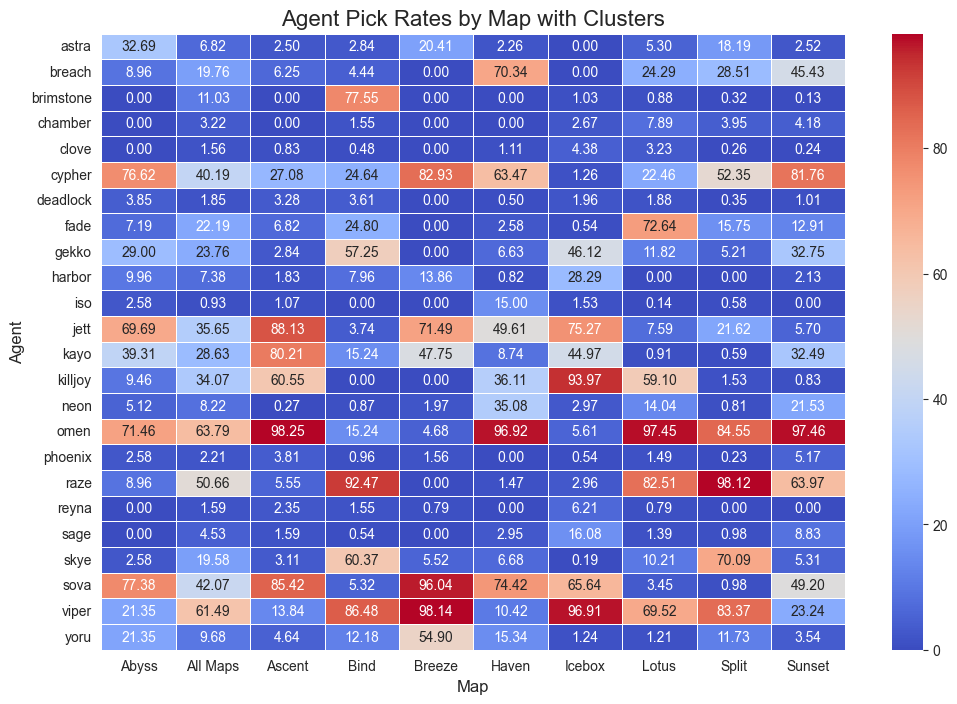

In [ ]:
from sklearn.cluster import KMeans
import numpy as np


X = heatmap_data.fillna(0).values

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

heatmap_data['Cluster'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Agent Pick Rates by Map with Clusters", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


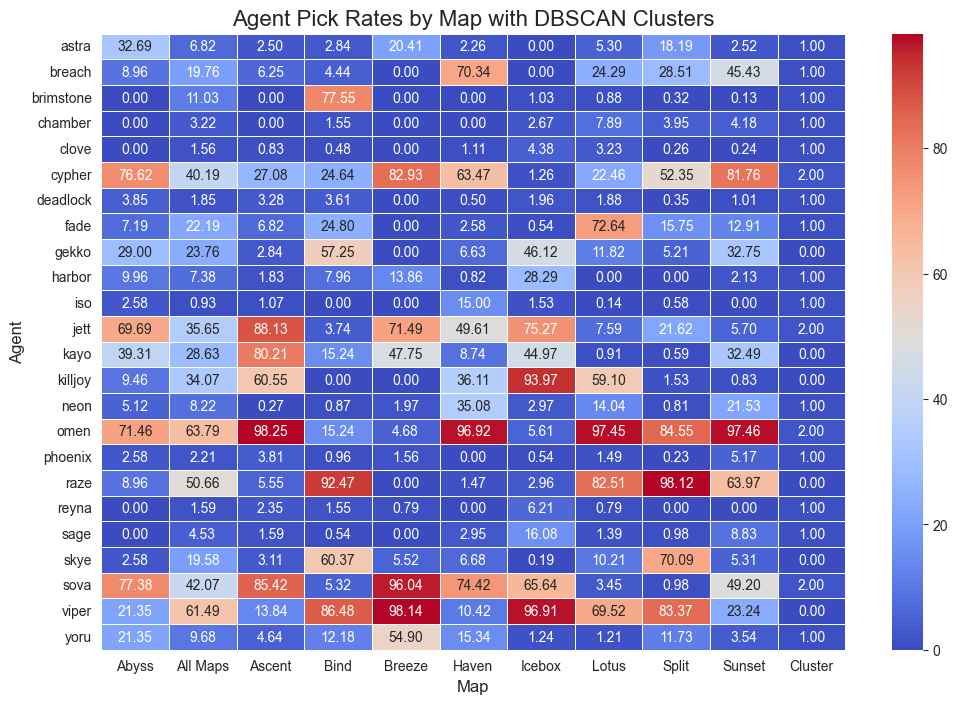

In [ ]:
from sklearn.cluster import DBSCAN

X = heatmap_data.fillna(0).values

dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X)

heatmap_data['DBSCAN Cluster'] = dbscan_labels

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.iloc[:, :-1], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Agent Pick Rates by Map with DBSCAN Clusters", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


Index(['Agent', 'Abyss', 'All Maps', 'Ascent', 'Bind', 'Breeze', 'Haven',
       'Icebox', 'Lotus', 'Split', 'Sunset', 'Cluster', 'DBSCAN Cluster'],
      dtype='object', name='Map')


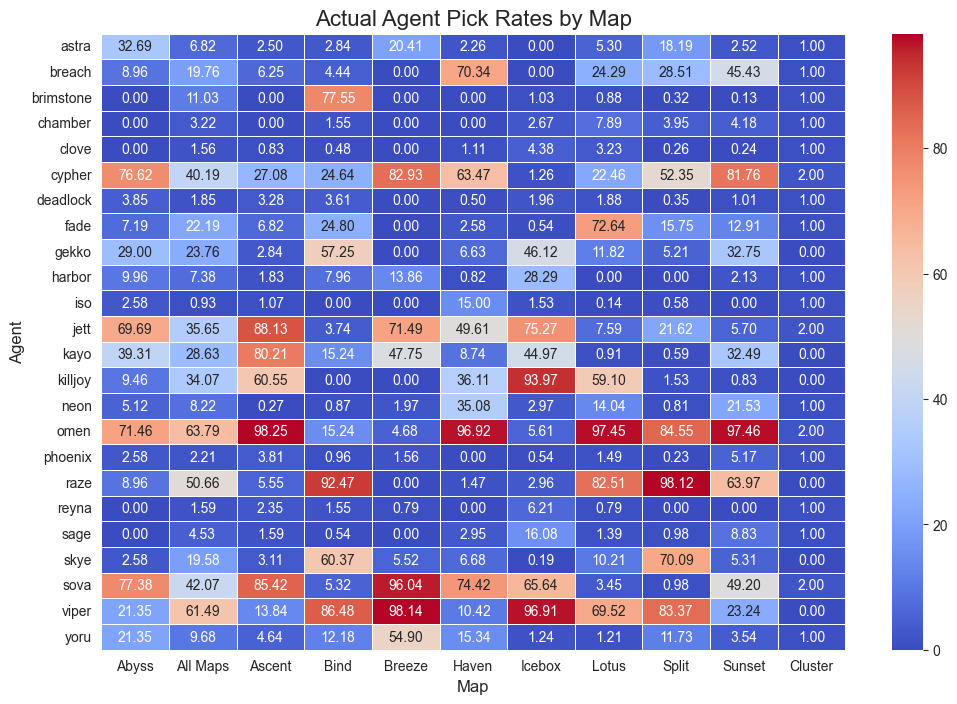

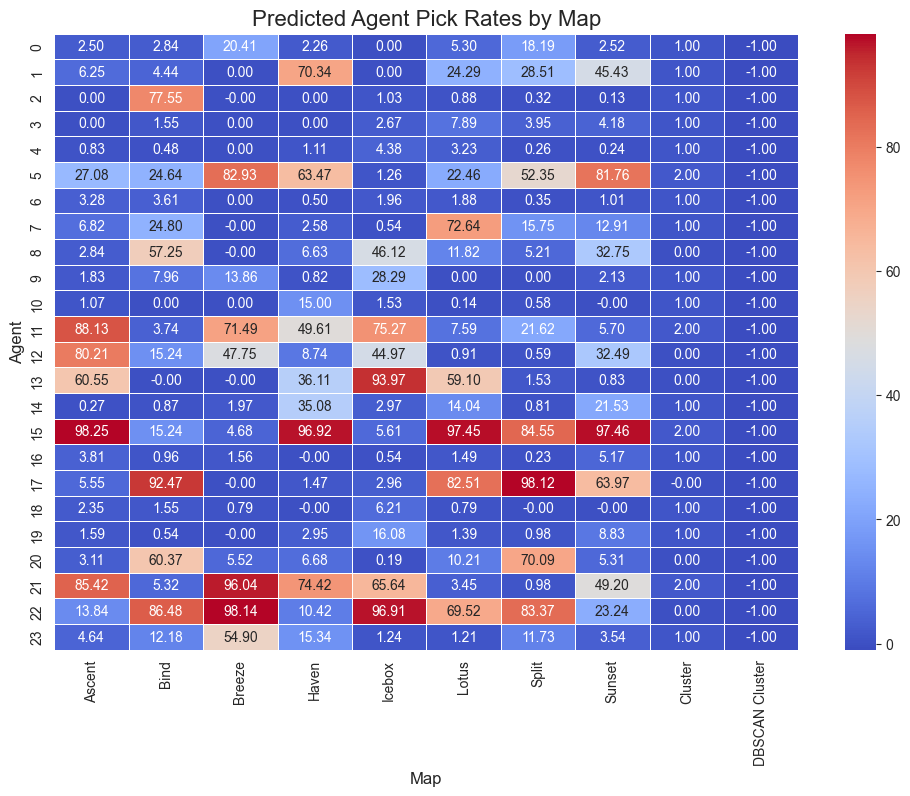

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


heatmap_data_reset = heatmap_data.reset_index()

regressor = LinearRegression()


predictions = {}
for map_name in heatmap_data.columns[2:]:
    X = pd.DataFrame({'Agent': heatmap_data_reset['Agent']})
    X = pd.get_dummies(X, drop_first=True)  
    y = heatmap_data_reset[map_name]
    

    regressor.fit(X, y)
    
    predictions[map_name] = regressor.predict(X)

predicted_df = pd.DataFrame(predictions)

print(heatmap_data_reset.columns)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_reset.set_index('Agent').drop(columns='DBSCAN Cluster'), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Actual Agent Pick Rates by Map", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(predicted_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Predicted Agent Pick Rates by Map", fontsize=16)
plt.xlabel("Map", fontsize=12)
plt.ylabel("Agent", fontsize=12)
plt.show()


Filtered Data contains 1297 rows.


C:\Users\yanap\AppData\Local\Temp\ipykernel_18556\3945707922.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_stats['Clutches (won/played)'] = pd.to_numeric(team_stats['Clutches (won/played)'], errors='coerce')


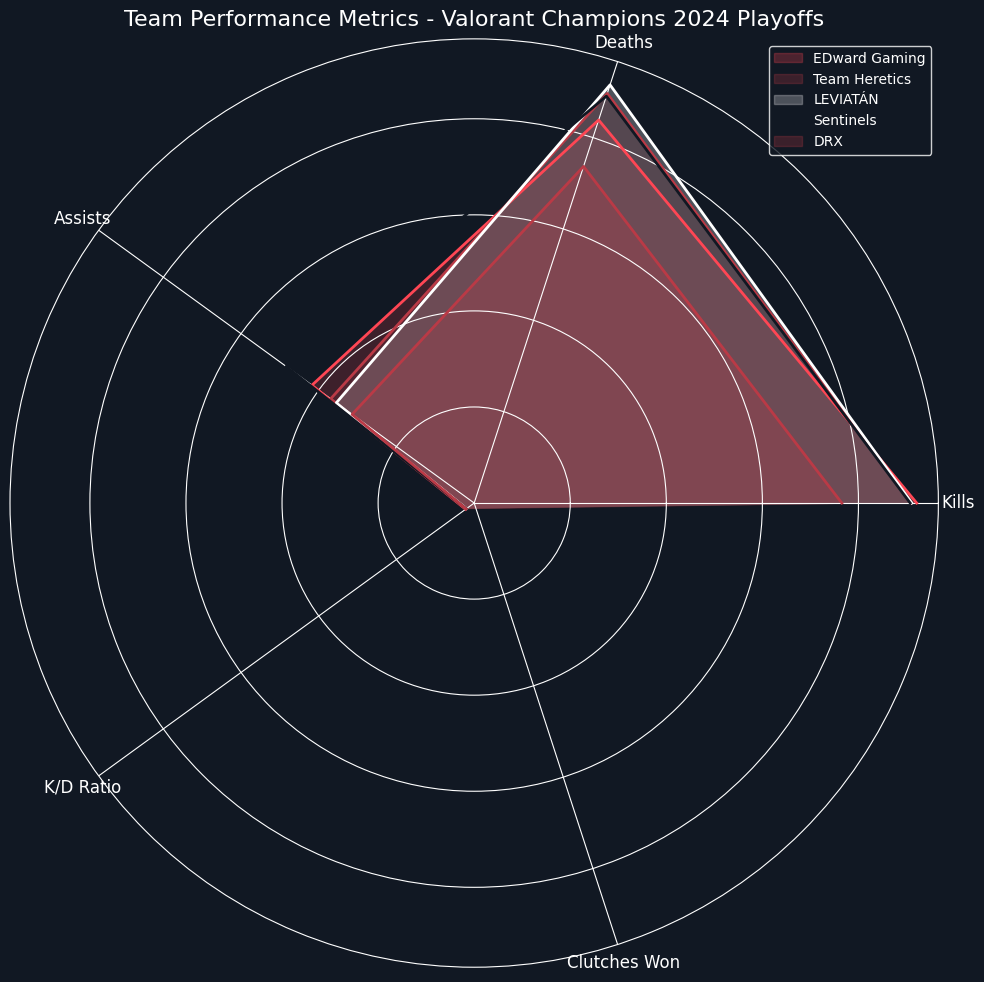

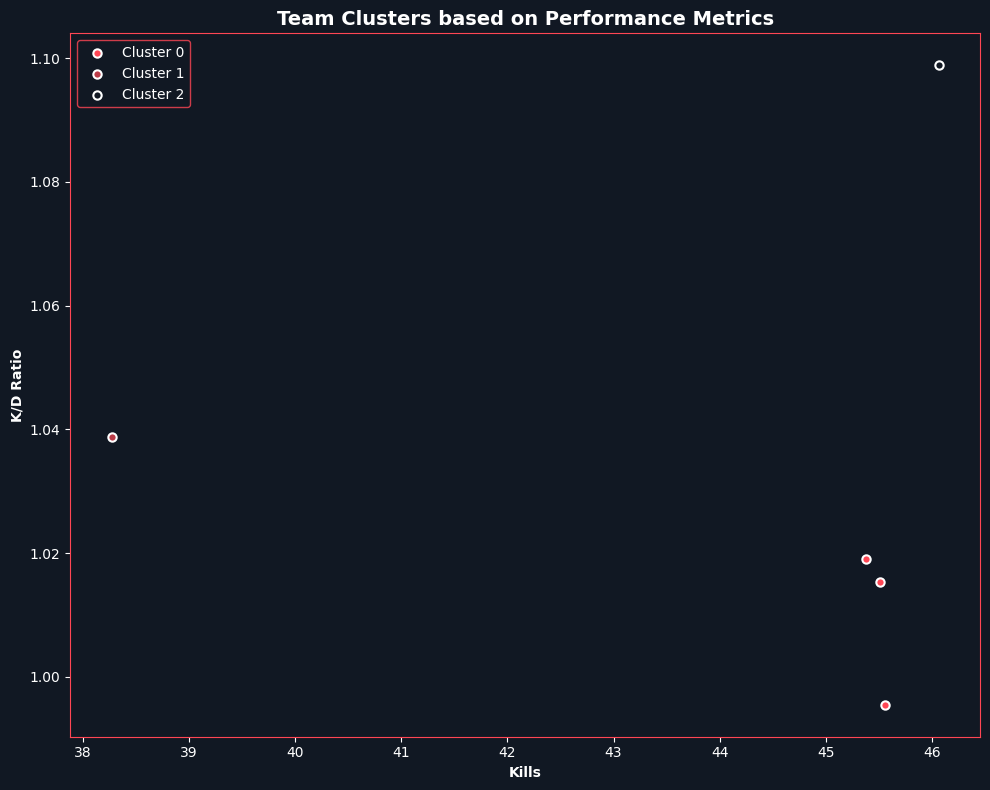

                   Kills     Deaths    Assists  K/D Ratio  Clutches Won  \
EDward Gaming  46.064286  41.921429  20.871429   1.098824           0.0   
Team Heretics  45.514970  44.826347  18.461078   1.015362           0.0   
LEVIATÁN       45.561983  45.768595  17.743802   0.995486           0.0   
Sentinels      45.383838  44.535354  24.191919   1.019052           0.0   
DRX            38.268293  36.841463  15.707317   1.038729           0.0   

               Cluster  
EDward Gaming        2  
Team Heretics        0  
LEVIATÁN             0  
Sentinels            0  
DRX                  1  


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "valorant_data/vct_2024/players_stats/players_stats.csv"
data = pd.read_csv(file_path)

filtered_data = data[data['Tournament'] == 'Valorant Champions 2024']
print(f"Filtered Data contains {len(filtered_data)} rows.")

top_teams = ['EDward Gaming', 'Team Heretics', 'LEVIATÁN', 'Sentinels', 'DRX']

team_data = {}
for team in top_teams:
    team_stats = filtered_data[filtered_data['Teams'] == team]
    
    team_stats['Clutches (won/played)'] = pd.to_numeric(team_stats['Clutches (won/played)'], errors='coerce')
   
    avg_stats = {
        'Kills': team_stats['Kills'].mean(),
        'Deaths': team_stats['Deaths'].mean(),
        'Assists': team_stats['Assists'].mean(),
        'K/D Ratio': (team_stats['Kills'].sum() / team_stats['Deaths'].sum()) if team_stats['Deaths'].sum() > 0 else 0,
        'Clutches Won': team_stats['Clutches (won/played)'].mean()
    }
    team_data[team] = avg_stats

metrics = ['Kills', 'Deaths', 'Assists', 'K/D Ratio', 'Clutches Won']
num_vars = len(metrics)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

colors = ['#ff4654', '#ba3a46', '#ffffff', '#111823', '#ba3a46']

plt.figure(figsize=(10, 10), facecolor='#111823')
plt.style.use('dark_background')
ax = plt.subplot(111, polar=True)

for i, (team, performance) in enumerate(team_data.items()):
    performance_values = [performance[metric] for metric in metrics]
    performance_values += performance_values[:1]
    angles_with_repeat = angles + angles[:1] 
    ax.fill(angles_with_repeat, performance_values, alpha=0.25, color=colors[i], label=team)
    ax.plot(angles_with_repeat, performance_values, color=colors[i], linewidth=2) 

ax.set_facecolor('#111823')
ax.set_yticklabels([]) 
ax.set_xticks(angles)
ax.set_xticklabels(metrics, fontsize=12, color='white')

plt.title('Team Performance Metrics - Valorant Champions 2024 Playoffs', fontsize=16, color='white')
plt.legend(facecolor='#111823', edgecolor='white', labelcolor='white', loc='upper right')

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

colors = ['#ff4654', '#ba3a46', '#111823', '#ffffff']
plt.style.use('dark_background')

clustering_data = pd.DataFrame(team_data).T  
clustering_data.fillna(0, inplace=True) 

scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=3, random_state=42) 
clustering_data['Cluster'] = kmeans.fit_predict(normalized_data)

plt.figure(figsize=(10, 8), facecolor=colors[2])
ax = plt.gca()
ax.set_facecolor(colors[2])

for cluster in set(clustering_data['Cluster']):
    cluster_data = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Kills'], cluster_data['K/D Ratio'], 
                color=colors[cluster], 
                label=f'Cluster {cluster}', 
                edgecolors=colors[3], 
                linewidth=1.5)

plt.xlabel('Kills', color=colors[3], fontweight='bold')
plt.ylabel('K/D Ratio', color=colors[3], fontweight='bold')
plt.title('Team Clusters based on Performance Metrics', 
          color=colors[3], fontsize=14, fontweight='bold')
plt.legend(frameon=True, facecolor=colors[2], edgecolor=colors[0])

plt.tick_params(colors=colors[3])
for spine in plt.gca().spines.values():
    spine.set_edgecolor(colors[0])

plt.tight_layout()
plt.show()

print(clustering_data)
